# Transfer learning with TensorFlow Hub
- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

TensorFlow Hub: a repository of pre-trained TensorFlow models

In [1]:
import numpy as np 
import time

import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf 
import tensorflow_hub as hub

### 1. 그대로 이용하기 

In [2]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
# MobileNetV2에 해당하는 다른 모델을 불러도 됨

In [6]:
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 0us/step


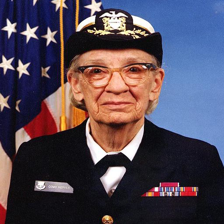

In [7]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [9]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [10]:
result = classifier.predict(grace_hopper[np.newaxis,...])

In [13]:
predicted_class = np.argmax(result[0], axis=-1)

In [17]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


'Military Uniform'

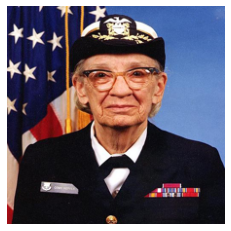

In [19]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
predicted_class_name.title()

### 2. headless model 이용한 transfer learning
- classification을 위한 top layer가 없는 모델

In [20]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [21]:
data_root

'/Users/wonji/.keras/datasets/flower_photos'

In [22]:
batch_size = 32
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_root), validation_split=0.2, subset='training', 
    seed=123, 
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [23]:
class_names = np.array(train_ds.class_names)
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [25]:
# transfer learning - model trainable=False하면 normalization layer는 별도로 추가해주는 것이 좋음
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [28]:
result_batch = classifier.predict(train_ds)
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=1)]

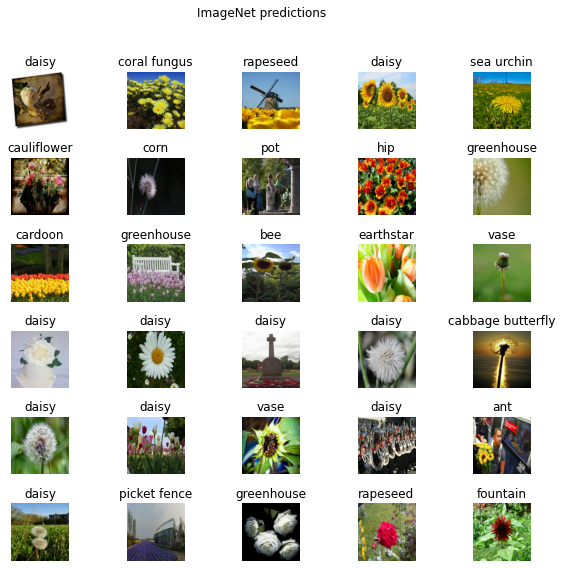

In [29]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [30]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # headless model 
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [48]:
print(feature_extractor_layer(image_batch).shape) 
# traind_ds -> normalization -> (첫번째 배치 샘플) image_batch, labels_batch
# tfhub의 모델 결과 = 1280차원 (feature extractor로 이용 - 배치크기 32 * 1280 차원 x 배치 개수 N)

(32, 1280)


In [33]:
num_classes = len(class_names)

model = tf.keras.Sequential([ # normalization layer는 없지만, input으로 사용될 train_ds는 사전에 normalized됨
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
print(model(image_batch).shape) # 배치크기 32 * 클래스 5개 

(32, 5)


In [35]:
# 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['acc'])

In [37]:
class CollectBatchStats(tf.keras.callbacks.Callback): # 자체 콜백
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()
    
batch_stats_callback = CollectBatchStats()
# 학습 with 직접 만든 콜백
history = model.fit(train_ds, epochs=2, callbacks=[batch_stats_callback])

Epoch 1/2
92/92 [==============================] - 45s 458ms/step - loss: 0.8058 - acc: 0.7143
Epoch 2/2
92/92 [==============================] - 42s 454ms/step - loss: 0.3855 - acc: 0.8695


In [ ]:
# dense Layer만 학습시키면 되므로 epochs이 많게 필요 X
# validation 의미없음 -> validation dataset 없이 fit

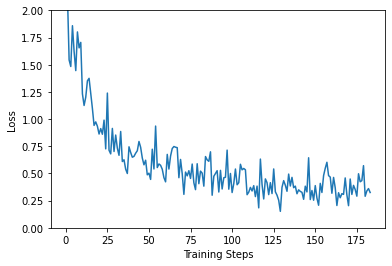

In [38]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

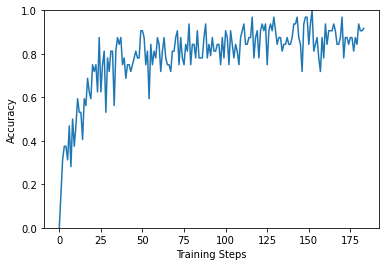

In [39]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [41]:
# 예측
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

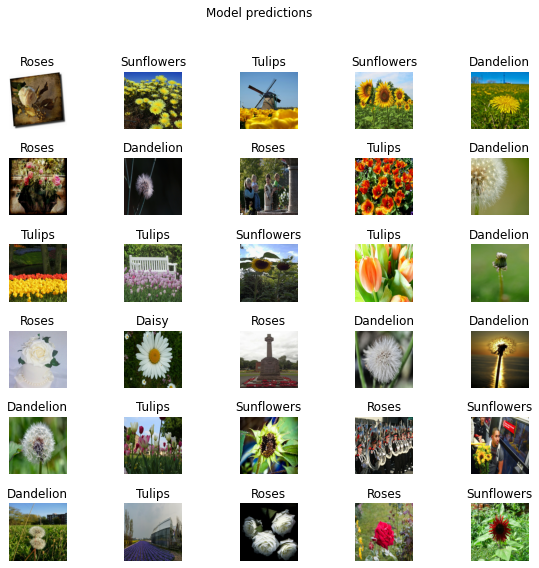

In [42]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

### 모델의 저장과 로드

In [43]:
t = time.time()
export_path = f'/tmp/saved_models/{int(t)}'
model.save(export_path)
print(export_path)

INFO:tensorflow:Assets written to: /tmp/saved_models/1610284125/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1610284125/assets


/tmp/saved_models/1610284125


In [44]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [45]:
abs(reloaded_result_batch - result_batch).max()

0.0